# Assignment 7 for Advanced Statistics,  26/03/2020

## Author: Carolina Hernández Oliver

## 1) Describe the data set

The iris data sets consists of 3 different types (Setosa, Versicolour, and Virginica) of irises’ petal and sepal length, stored in a 150x4 numpy.ndarray.

The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

In [ ]:
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
import numpy as np
import pymc3 as pm

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [203]:
# Importing data with sklearn

iris = datasets.load_iris()

# Describing the data

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [208]:
# Importing now with seaborn 

iris_df = sns.load_dataset("iris")
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


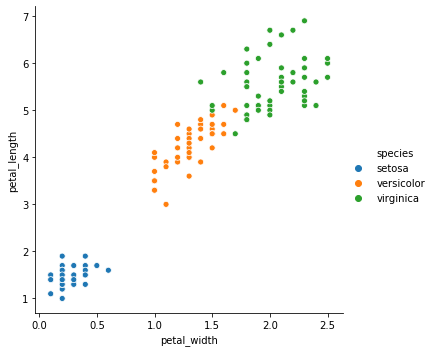

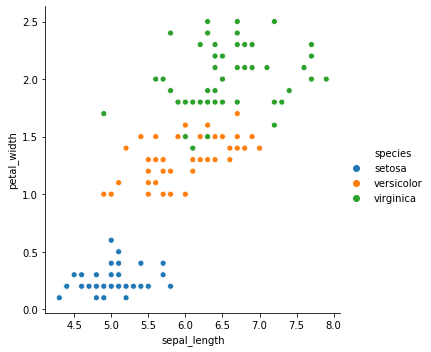

In [220]:
# Visualizing some data relationship: petal_length with petal_width, and petal_width with sepal_length.
# We can appreciate there is an association between this pair of variables: 
# As petal length increases with petal width
# And also petal width increases with sepal length

sns.relplot(x="petal_width", y="petal_length", hue= "species", data=iris)

sns.relplot(x="sepal_length", y="petal_width", hue= "species", data=iris)

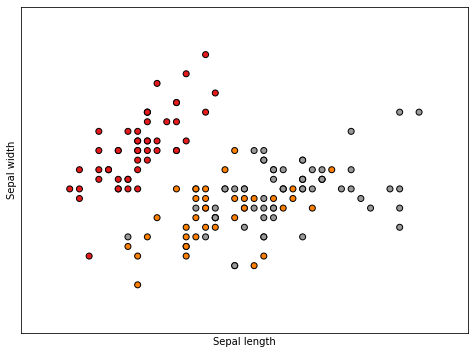

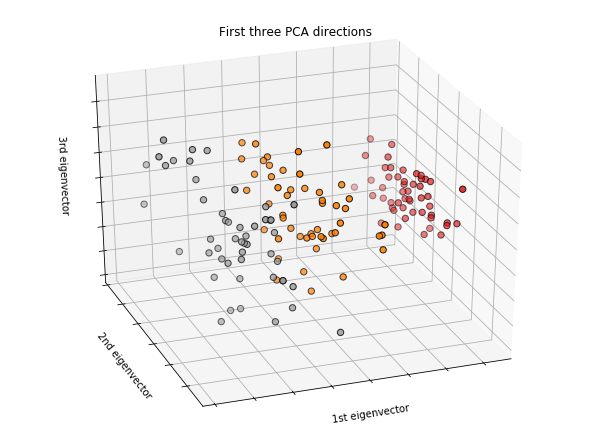

In [7]:
# Taking the first two features: sepal length and sepal width.

X = iris.data[:, :2]  
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To get a better understanding of interaction of the dimensions
# Ploting the first three PCA dimensions

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

## 2) Using pyMC3, we want to infer the parameters of the following models:
    a) The mean and standard deviation of the distribution of one feature chosen by you, that we assume as normally distributed.

In [58]:
import pymc3 as pm
# Computing the mean and standard deviation of petal length feature

mean_petal_length = iris[["petal_length"]].mean()
sd_petal_length = iris[["petal_length"]].std()

print("The standard deviation is: %f with mean: %f "%(sd_petal_length, mean_petal_length))

The standard deviation is: 1.765298 with mean: 3.758000 


In [63]:
# Generate the dataset, we are only interested in one feature:
obs_y = iris[["petal_length"]]

# Model the data with a simple Bayesian model:
with pm.Model() as Model:
    # The probability distribution of our data we assume is going to follow a normal distribution
    
    # Setting the prior distributions (beliefs) to the 2 parameters we are trying to estimate:
    stdev = pm.HalfNormal('stdev',sigma = 1.) # A halfnormal stops at 0. Sigma can NOT go to the negative.
    mu = pm.Normal('mu',mu=0.0, sigma = 1.) # I believe that my mu parameter follows a normal centered around 0,
    #..somewhere within one standar deviations at zero
    
    # What data is going to use pymc3 to estimate the parameters of our model? obs_y
    y = pm.Normal("y", mu= mu , sigma= stdev, observed = obs_y )
    
    # Run the inference algorithm : Markov Chain Monte Carlo
    trace = pm.sample(2000, step=pm.Metropolis()) # Take random samples from posterior distributions
    # This is not going to return a simple point estimate...
    # By looking at the data, what are the most likely values for mu and sd that produced our data.
    # This is going to be answered with a probability distribution that represents the uncertainty that the model has about the true values of those parameters 
    burned_trace = trace[2000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [stdev]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:45<00:00, 47.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1252d1430>,
      dtype=object)

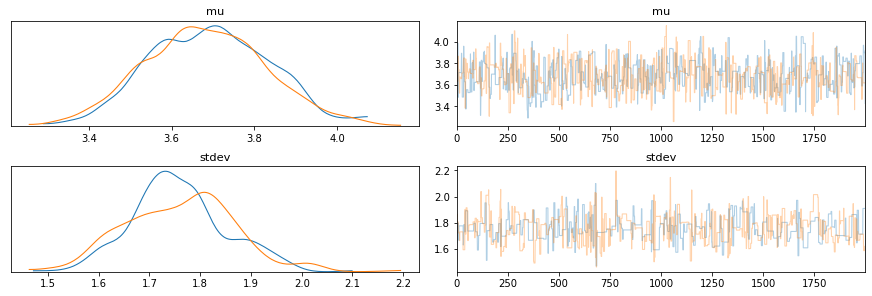

In [70]:
# PyMC3 have functions that allow us to follow for each parameter if it have converted.

pm.traceplot(trace, varnames=["mu","stdev"])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x127343c10>,
      dtype=object)

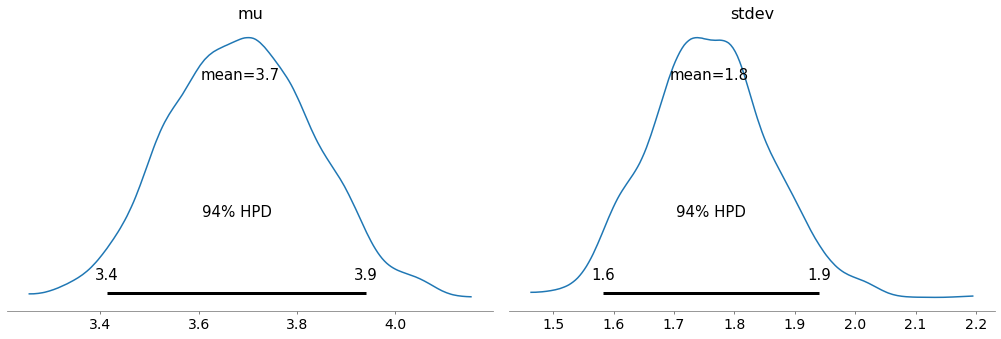

In [78]:

pm.plot_posterior(trace, var_names=["mu","stdev"])


Here, we can see the distribution of the possible values for each one of the parameters of the model. 

The traceplot shows the posterior distribution after uploading my beliefs and running the Metropolis algorithm to finally know the most probable values. Since we have explored the conformational space by the Algorithm, we have update our beliefs about the distribution.

The last plot show us the kernel density plot for each one of the parameters, the obtained mean for the distribution and a confidence interval of 95% for each parameter: 95% of possibility of finding the value of the parameter inside this range. If I would move away this region I will arrive to posterior distributions that, according to the data, are really not probable.

From 3.4 to 3.9 is the error I am commiting infering the mean, and from 1.6 to 1.9 is the error for the stdev

    b) The Petal Width as linear function of the other three features.

### Petal_width = a * Petal_length + b * Sepal_length + c * Sepal_width

In [236]:
# Preparing data

iris = datasets.load_iris() # ARRAY

iris_ds = pd.DataFrame(iris.data)
iris_ds.columns = ['petal_length','petal_width','sepal_length','sepal_width']

Yb = iris_ds['petal_width']
Xb = iris_ds.drop(columns=['petal_width'])

In [242]:
XT_X = np.matmul(Xb.values.T, Xb.values)
XT_X_inverse = np.linalg.inv(XT_X)
a, b, c = np.matmul(np.matmul(XT_X_inverse, Xb.values.T), Yb)

print('a (petal_length)      :', a)
print('b (sepal_length)      :', b)
print('c (sepal_width)       :', c)
print()

print('y hat', '  y')
for _, sample in iris_ds[:10].iterrows():
    y_hat = a * sample['petal_length'] + b * sample['sepal_length'] + c * sample['sepal_width']
    print(round(y_hat, 2), '  ', sample['petal_width'])

a (petal_length)      : 0.8377894505384711
b (sepal_length)      : -0.668938463282445
c (sepal_width)       : 0.5561053057683356

y hat   y
3.45    3.5
3.28    3.0
3.18    3.2
2.96    3.1
3.36    3.6
3.61    3.9
3.08    3.4
3.3    3.4
2.86    2.9
3.16    3.1


In [243]:
def calculate_mean_squared_error(a, b, c, data):
    squared_error = 0
    for _, sample in iris_ds.iterrows():
        prediction = a * sample['petal_length'] + b * sample['sepal_length'] + c * sample['sepal_width']
        squared_error += (sample['petal_width'] - prediction)**2
    return squared_error / len(iris_ds)

calculate_mean_squared_error(a, b, c, iris_ds)

0.0989691149042017


The mean squared error of the parameters of the model (petal_width = a * petal_length + b * sepal_length + c * sepal_width) is 0.09896 when:

a = 0.8377

b = -0.6689

c = 0.5661

## 3) Clusterize the plants according to its features and analyse the results of the clusters as indication of the type of plant.



Clustering is a type of unsupervised machine learning which aims to find homogeneous subgroups such that objects in the same group (clusters) are more similar to each other than the others.  

In [106]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.datasets import load_iris
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix,classification_report

In [110]:
# Setting variables:
iris_dataset = datasets.load_iris()

x = scale(iris_dataset.data) # Our training data. Species in a categorical variable
y = pd.DataFrame(iris_dataset.target) # Our target variable calling the DataFrame constructor. Is the one containning species label.
# y are the true outcomes. The predicted outcomes are in the kmeans model generated with .fit kmeans_clustering

variable_names = iris_dataset.feature_names # Storing the features names in a variable


KMeans is a clustering algorithm which divides observations into k clusters. Since we can dictate the amount of clusters, it can be easily used in classification where we divide data into clusters which can be equal to or more than the number of classes.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexes/base.py:111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = op(self.values, np.asarray(other))


Text(0.5, 1.0, 'K-means Classification')

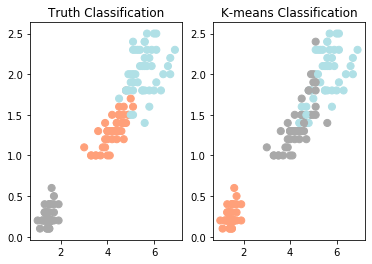

In [119]:
# Initiate a kmeans object:

KMeans_clustering = KMeans(n_clusters=3, random_state=5)
KMeans_clustering.fit(x) # Computing the k-means clustering # Default models of parameters.

# Plotting the cluster in a scatterplot:

iris_df = pd.DataFrame(iris_dataset.data)
iris_df.columns =['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

y.columns == ['Targets']

# Setting colors:

color_theme = np.array(['darkgray','lightsalmon','powderblue'])

plt.subplot(1,2,1) # Creating a subplot that has 1 row and 2 columns
plt.scatter(x= iris_df.petal_length, y =iris_df.petal_width, c=color_theme[iris_dataset.target], s=50, )# Exactly what position I want
plt.title('Truth Classification')

plt.subplot(1,2,2) # 
plt.scatter(x= iris_df.petal_length, y =iris_df.petal_width, c=color_theme[KMeans_clustering.labels_], s=50, )
# Labels that are predicted by our clustering model.
plt.title('K-means Classification')


Text(0.5, 1.0, 'K-means Classification')

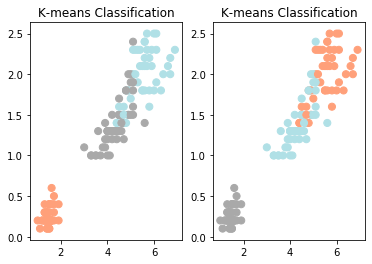

In [121]:
relabel= np.choose(KMeans_clustering.labels_,[2,0,1]).astype(np.int64)

plt.subplot(1,2,1) # 
plt.scatter(x= iris_df.petal_length, y =iris_df.petal_width, c=color_theme[KMeans_clustering.labels_], s=50, )
# Labels that are predicted by our clustering model.
plt.title('K-means Classification')

plt.subplot(1,2,2) # 
plt.scatter(x= iris_df.petal_length, y =iris_df.petal_width, c=color_theme[relabel], s=50, )
# Labels that are predicted by our clustering model.
plt.title('K-means Classification')


In [122]:
# Evaluating the clustering:

print(classification_report(y, relabel))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.23      0.22      0.23        50
           2       0.26      0.28      0.27        50

    accuracy                           0.50       150
   macro avg       0.50      0.50      0.50       150
weighted avg       0.50      0.50      0.50       150



The recall means “for all instances that were actually positive, what percent was classified correctly?”.  
The precision will be “for all instances classified positive, what percent was correct?”.  
The f1-score is the harmonic mean between precision and recall.  
The support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing.   
As one can see: The classifier is better to find class 0 over class 1 and 2, and the average support is the same for three cases.  
Is a good classification for class 0, but not for classes 1 and 2.

## 4) Use a random forest classification and express which is the importance of each feature to infer the type of plant.

Random forest model is a classification model where we estimate the relationship between a categorical target variable and its numeric predictors, helping predict the target variable.

Since species is the only categorical variable in the dataset, is the target (predicted,Y) variable. The rest are predictors.

In [140]:
import pandas as pd

from pandas import DataFrame


In [163]:
iris_rfc = pd.DataFrame(iris.data)

iris_rfc.columns =['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# y.columns == ['Targets']

In [168]:
x_df = pd.DataFrame(iris_dataset.data) # Our training data. Species in a categorical variable
y = pd.DataFrame(iris_dataset.target)

In [169]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_df, y, test_size=0.3)


from sklearn.ensemble import RandomForestClassifier

model_rfc = RandomForestClassifier(n_estimators=200)
model_rfc.fit(x_train, y_train)

model_rfc_pred = model_rfc.predict(x_test)


<ipython-input-169-2b8d1a538b8a>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rfc.fit(x_train, y_train)


A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True negatives and False Negatives are used to predict the metrics of a classification report as shown below.    
In the table:   
0 = setosa  
1 = versicolor  
2 = virginica  

In [170]:
from sklearn.metrics import classification_report
print(classification_report(y_test,model_rfc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.94      0.89      0.92        19
           2       0.89      0.94      0.92        18

    accuracy                           0.93        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.93      0.93      0.93        45



Precision is the ability of a classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”.  
Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”.  
The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.  
Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.  
This model is quite good.

In [171]:
print("RF train accuracy: %0.3f" % model_rfc.score(x_train, y_train))
print("RF test accuracy: %0.3f" % model_rfc.score(x_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.933


Prior to inspecting the feature importances, it is important to check that the model predictive performance is high enough. Indeed there would be little interest of inspecting the important features of a non-predictive model.
From the previous step, one can observe that the train accuracy is very high (the forest model has enough capacity to completely memorize the training set).

In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [ ]:
x, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

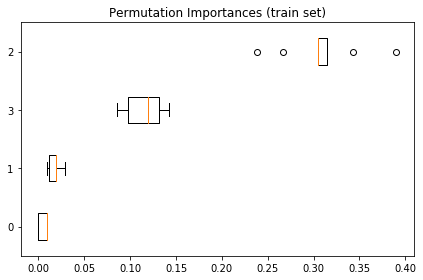

In [172]:
# We are going to discover which are the most important features
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

result = permutation_importance(model_rfc, x_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

# 0 = sepal_length
# 1 = sepal_width
# 2 = petal_length
# 3 = petal_width


The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. The permutation_importance function calculates the feature importance of estimators for a given dataset. In this case, we analyze the feature importance for all the features in our iris data: petal width, sepal with, petal length and sepal length.
Also, when two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance for both features.
From the permutation importance plot that is represented above, it can be observed that permuting a feature drops the accuracy until 0.4, which would suggest that there is one important feature. The permutation importance is calculated on the training set to show how much the model relies on each feature during training.

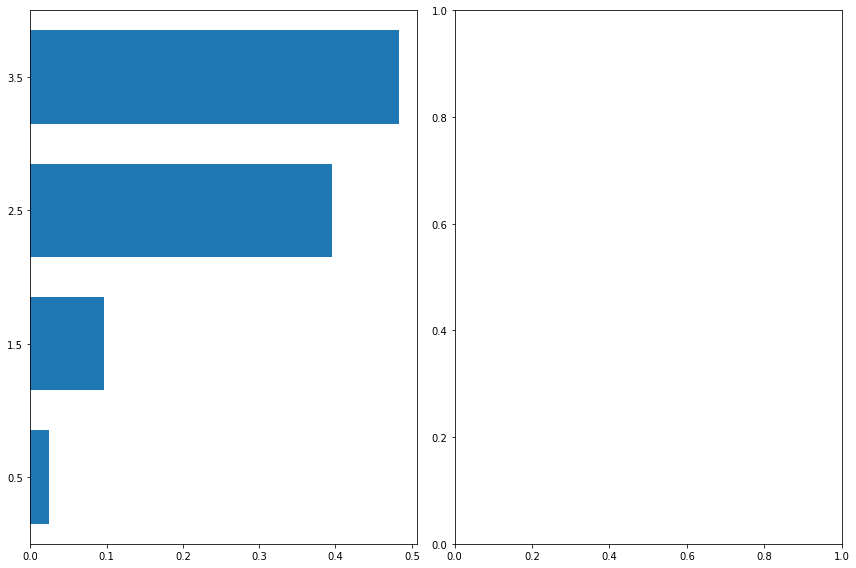

In [176]:
result = permutation_importance(model_rfc, x_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(model_rfc.feature_importances_)
tree_indices = np.arange(0, len(model_rfc.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         model_rfc.feature_importances_[tree_importance_sorted_idx], height=0.7)
# ax1.set_yticklabels(iris.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(model_rfc.feature_importances_)))
# ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=iris.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

 We can conclude from this section that the most important feature is petal_length, followed by petal_width.

## 5. Analyze the dependence (or independence) of each one of the features within the data set.

One variable is independent when its variation is not associated with changes in the other variable.

Here we can see the correlation matrix to see variables wich best correlate each other.

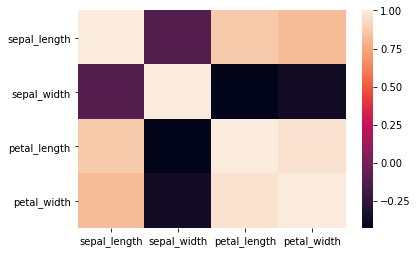

In [196]:
# According to the correlation matrix results:
#Sepal_Length and Petal_Width have possitive correlation which is proved by the plot above

import seaborn as sns
import matplotlib.pyplot as plt 


corr = iris_rfc.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()


On this heatmap, when there is no correlation between 2 variables (when correlation is 0 or near 0) the color is purple. The lightest brown means there is a perfect positive correlation, while the dark means there is a negative correlation.   
Following this criteria:  
There is no correlation between sepal width and sepal length.  
There is a negative correlation between:
- sepal width and petal length
- sepal width and petal width 

There is a high positive correlation between petal width and petal length.  
There is a light positive correlation between petal length and sepal length.  
There is an intermedium positive correlation between petal width and sepal length.  
This means that the more dependent variables are petal width and petal length (1), and there is no dependency between the variables sepal width and sepal length.

## 6) If we assign the following numerical values: Setosa=0, Versicolour=1, and Virginica=2 and we propose the following causal model:
   ### Sepal Length -> Sepal Width -> Plant Type <- Petal Width <- Petal Length
     a) Which relation of independence we should expect between Sepal Length and Petal Length? Check it.
     b) And if we condition on Plant type? 
     c) And if we condition on Petal Width?

In [197]:
# A -> B -> C <- D <-E

causal_graph = [
    #  A      B     C      D      E
    [False, True, False, False, False],  # A causes ...
    [False, False, True, True, False],   # B causes ...
    [False, False, False, False, False],  # C causes ...
    [False, False, True, False, False],  # D causes ...
    [False, False, False, True, False], # E causes ...
]

In [200]:
iris['species'].replace("iris_setosa", 0 , inplace = True)
iris['species'].replace("iris_versicolour", 1 , inplace = True)
iris['species'].replace("iris_virginica", 2 , inplace = True)

KeyError: 'species'

In [ ]:
from causalinference import CausalModel
from causalinference.utils import random_data


In [180]:
from collections import namedtuple
from sklearn import datasets

data = datasets.load_iris(beta=5,
        num_common_causes=2,
        num_instruments=1, 
        treatment_is_binary=True)

TypeError: load_iris() got an unexpected keyword argument 'beta'